In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import nltk
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load your dataset (replace with your actual file path)
# Example for a CSV file with a text field and labels
df = pd.read_csv('test_train_dataset/train_sentiment.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (80000, 6)
                                                text  labels  preds  feedback  \
0  that might sound silly but if i havent pre-ord...       0    NaN       NaN   
1  googledofhey - i have no idea where else to tu...       1    NaN       NaN   
2        i just achieved the mana sponge achievement       1    NaN       NaN   
3  i go through this often when in a high up loca...       0    NaN       NaN   
4  mr paul christoph in sandrock best pubg teamma...       2    NaN       NaN   

   retrain_labels  retrained_preds  
0             NaN              NaN  
1             NaN              NaN  
2             NaN              NaN  
3             NaN              NaN  
4             NaN              NaN  


In [3]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
text                  83
labels                 0
preds              80000
feedback           80000
retrain_labels     80000
retrained_preds    80000
dtype: int64


In [4]:
# List the column names you want to drop
columns_to_drop = ['preds', 'feedback', 'retrain_labels', 'retrained_preds']  # replace with your actual column names

# Drop them
df = df.drop(columns=columns_to_drop)

print("Columns dropped successfully!")
print(df.head())

Columns dropped successfully!
                                                text  labels
0  that might sound silly but if i havent pre-ord...       0
1  googledofhey - i have no idea where else to tu...       1
2        i just achieved the mana sponge achievement       1
3  i go through this often when in a high up loca...       0
4  mr paul christoph in sandrock best pubg teamma...       2


In [5]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
text      83
labels     0
dtype: int64


In [6]:
# Basic stats on text length
df['text'] = df['text'].fillna('')
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

print("\nText length statistics:")
print(df['text_length'].describe())
print("\nWord count statistics:")
print(df['word_count'].describe())


Text length statistics:
count    80000.000000
mean       137.139500
std        174.851991
min          0.000000
25%         54.000000
50%         97.000000
75%        169.000000
max       7643.000000
Name: text_length, dtype: float64

Word count statistics:
count    80000.000000
mean        25.487638
std         33.303247
min          0.000000
25%         10.000000
50%         17.000000
75%         31.000000
max       1415.000000
Name: word_count, dtype: float64


In [7]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
text           0
labels         0
text_length    0
word_count     0
dtype: int64


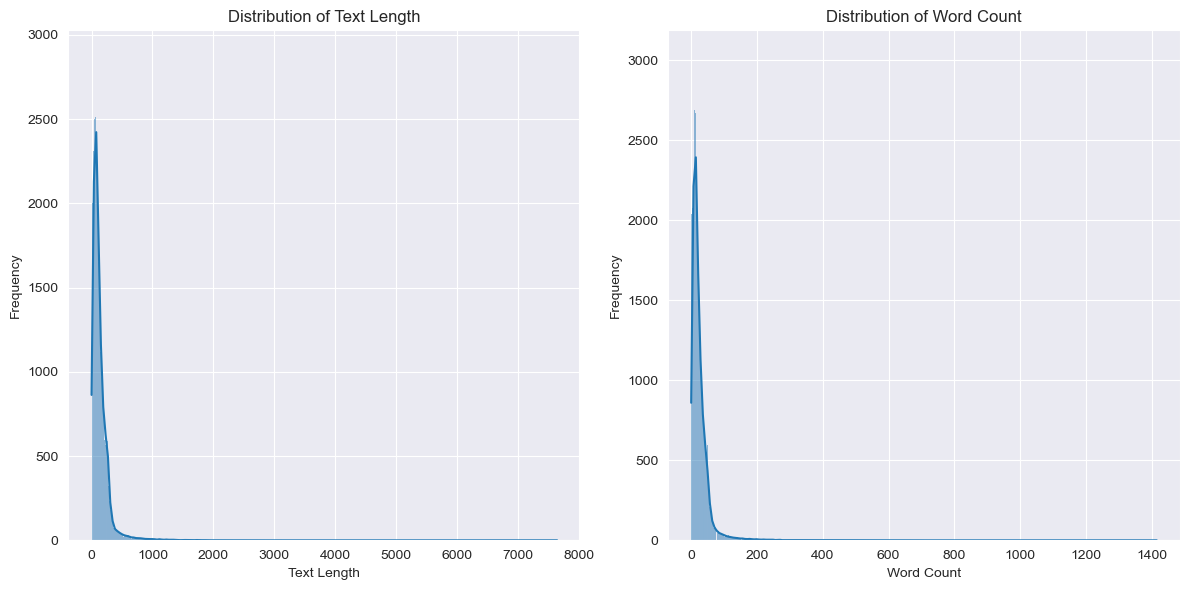

In [8]:
# Plot text length distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('text_distribution.png')
plt.show()

In [9]:
# Text cleaning function
def clean_text(text):
    """
    Clean and preprocess text data
    """
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove mentions and hashtags for social media data
        text = re.sub(r'@\w+|#\w+', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize text
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens back into text
        cleaned_text = ' '.join(tokens)

        return cleaned_text
    else:
        return ""

# Apply cleaning function
df['cleaned_text'] = df['text'].apply(clean_text)

In [10]:
# Display a sample of original vs cleaned text
print("\nOriginal vs Cleaned Text:")
for i in range(3):  # Show 3 examples
    print(f"Original: {df['text'].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_text'].iloc[i][:100]}...")
    print('-' * 80)


Original vs Cleaned Text:
Original: that might sound silly but if i havent pre-ordered fifa does that mean i cant play the free trial fo...
Cleaned: might sound silly havent preordered fifa mean cant play free trial hour...
--------------------------------------------------------------------------------
Original: googledofhey - i have no idea where else to turn for help i have a google sheets file that i used to...
Cleaned: googledofhey idea else turn help google sheet file used today havent able open since...
--------------------------------------------------------------------------------
Original: i just achieved the mana sponge achievement...
Cleaned: achieved mana sponge achievement...
--------------------------------------------------------------------------------


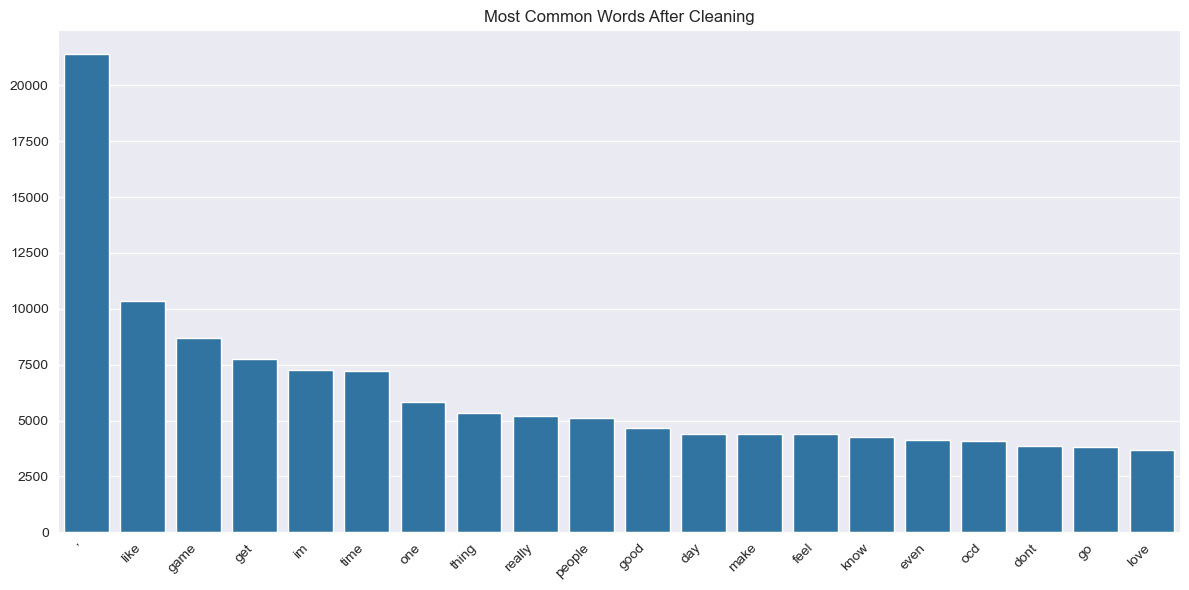

In [11]:
# Analyze most common words
all_words = ' '.join(df['cleaned_text']).split()
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

plt.figure(figsize=(12, 6))
words, counts = zip(*most_common)
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Common Words After Cleaning')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('common_words.png')
plt.show()

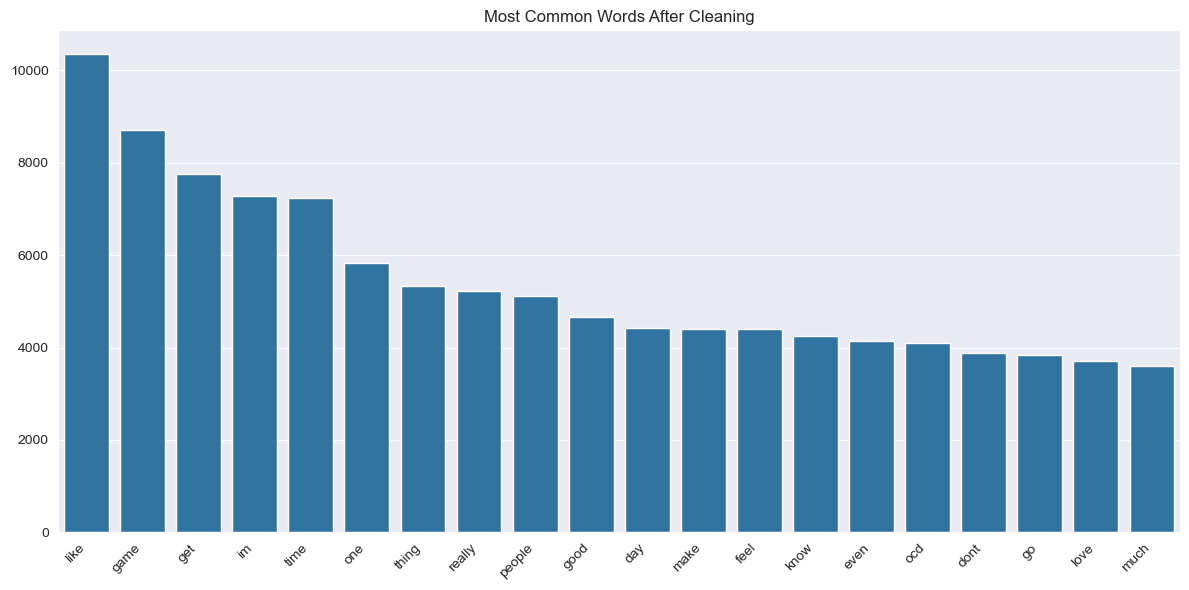

In [12]:
import re

# Define a cleaning function
def clean_text_again(text):
    # Remove all non-letter characters (keep only a-z and A-Z)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Optionally, make everything lowercase
    text = text.lower()
    return text

# Apply to your dataframe
df['cleaned_text'] = df['cleaned_text'].apply(clean_text_again)

# Analyze most common words
all_words = ' '.join(df['cleaned_text']).split()
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

plt.figure(figsize=(12, 6))
words, counts = zip(*most_common)
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Common Words After Cleaning')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('common_words.png')
plt.show()

In [13]:
# Split data into training and testing sets
X = df['cleaned_text']
y = df['labels']  # Replace 'label' with your target column name
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (64000,)
Testing set shape: (16000,)


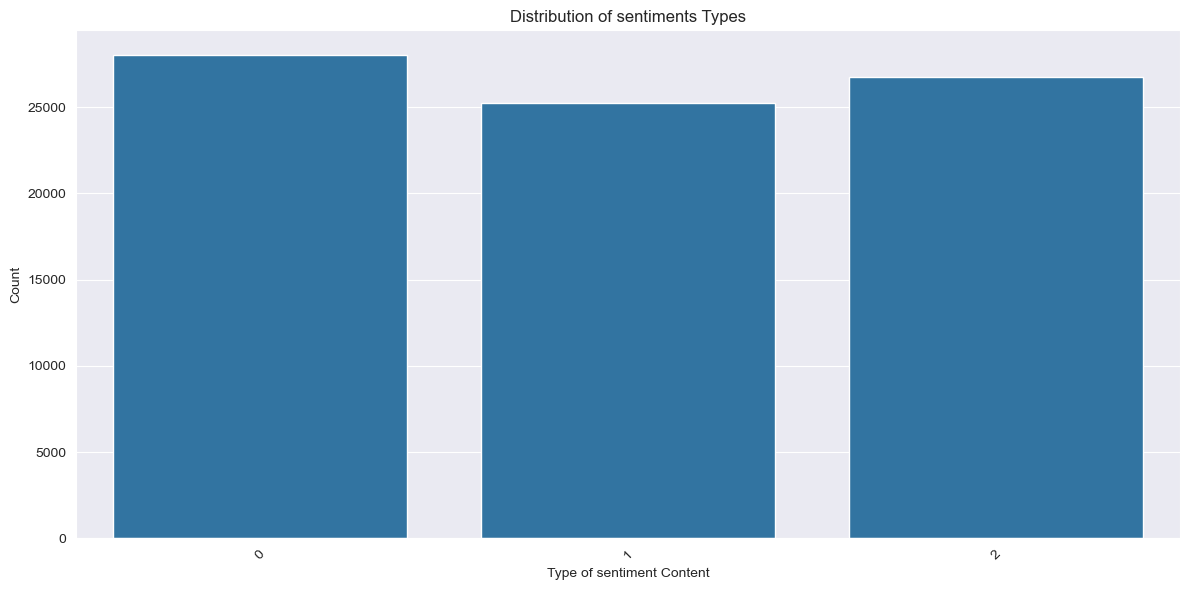

In [14]:
#  Visualization of labels types distribution
plt.figure(figsize=(12, 6))
type_counts = df['labels'].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.title('Distribution of sentiments Types')
plt.xlabel('Type of sentiment Content')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

In [15]:
# Define keyword patterns for each negative content category
content_type_patterns = {
    'harassment': [
        # Original patterns
        r'\b(harass|bully|stalk|threaten|intimidate|torment|mock|ridicule|taunt|belittle|humiliate)\w*\b',
        r'\b(shut up|get lost|loser|stupid|idiot|dumb|annoying|pathetic|creep)\b',
        r'\b(go away|leave me alone|stop following|unwanted|unwelcome)\b',
        # Additional patterns
        r'\b(troll|insult|offend|bother|pester|provoke|antagonize|hassle)\w*\b',
        r'\b(jerk|moron|fool|incompetent|worthless|useless|failure|joke|awful)\b',
        r'\b(pestering|bothering|annoying|irritating|frustrating|infuriating)\w*\b',
        r'\b(get out|buzz off|back off|stay away|leave|block|ignore|rejected)\b',
        r'\b(ugly|fat|skinny|short|tall|looks|appearance|face|body|weight)\b'
    ],

    'hate_discrimination': [
        # Original patterns
        r'\b(racist|sexist|homophobic|transphobic|xenophobic|bigot|prejudice|discriminate)\w*\b',
        r'\b(hate|despise|detest|abhor|loathe)\w*\b',
        r'\b(gender|race|ethnicity|religion|sexuality|disability|age)\b',
        r'\b(stereotype|bias|unfair|inequality|segregation)\b',
        # Additional patterns
        r'\b(jew|muslim|christian|hindu|buddhist|atheist|religious|white|black|asian|latino|hispanic)\w*\b',
        r'\b(minority|majority|privilege|oppression|supremacy|inferior|superior)\w*\b',
        r'\b(immigrant|foreigner|alien|refugee|outsider|invader|invasion)\w*\b',
        r'\b(man|woman|boy|girl|male|female|lgbt|gay|lesbian|trans|queer|straight)\b',
        r'\b(misogyny|misandry|feminism|patriarchy|sexism|racism|ableism|ageism)\w*\b',
        r'\b(slur|offensive|insensitive|triggered|snowflake|woke|politically correct)\b'
    ],

    'spam_scam': [
        # Original patterns
        r'\b(spam|scam|fraud|phishing|hack|virus|malware|trojan|fake|bogus)\w*\b',
        r'\b(click here|free offer|limited time|guarantee|prize|winner|discount|promotion)\b',
        r'\b(bank account|credit card|password|login|verify|authenticate|urgent|important)\b',
        r'\b(million dollars|lottery|inheritance|prince|overseas|foreign)\b',
        # Additional patterns
        r'\b(advertisement|ad|advert|marketing|sell|selling|sold|buy|buying|bought|purchase)\w*\b',
        r'\b(money|cash|dollar|euro|bitcoin|crypto|currency|payment|transaction|wallet)\b',
        r'\b(invest|investment|stock|profit|earn|earning|income|rich|wealth|wealthy)\b',
        r'\b(offer|deal|bargain|sale|cheap|expensive|affordable|cost|price|value)\b',
        r'\b(product|service|merchandise|item|goods|subscription|membership)\b',
        r'\b(link|url|website|email|contact|sign up|register|download|upload|install)\b',
        r'\b(opportunity|chance|lucky|fortunate|selected|chosen|special|exclusive)\b',
        r'\b(business|company|corporation|enterprise|organization|agency|firm)\b'
    ],

    'violence_abuse': [
        # Original patterns
        r'\b(violence|violent|abuse|assault|attack|threat|harm|hurt|injure|wound|kill)\w*\b',
        r'\b(beat|hit|punch|kick|slap|stab|shoot|murder|strangle|choke)\b',
        r'\b(weapon|gun|knife|bomb|explosive|dangerous|deadly|lethal)\b',
        r'\b(blood|pain|suffer|victim|torture|brutal|savage|cruel)\b',
        # Additional patterns
        r'\b(die|death|dead|suicide|suicidal|fatal|fatality|casualty)\b',
        r'\b(rape|molest|grope|fondle|sexually|assault|harass|inappropriate touch)\b',
        r'\b(cut|slash|slice|carve|mutilate|disfigure|dismember|decapitate)\b',
        r'\b(fight|brawl|battle|combat|conflict|war|warfare|struggle|clash)\b',
        r'\b(horror|terror|terrify|horrify|scare|fear|frightening|scary|disturbing)\b',
        r'\b(trauma|traumatize|shock|shell-shock|ptsd|hurt|wounded|damaged)\b',
        r'\b(burn|fire|flame|incinerate|scorch|melt|explode|explosion|blast)\b',
        r'\b(poison|toxic|venom|drug|overdose|lethal dose|deadly substance)\b'
    ],

    'profanity_vulgarity': [
        r'\b(fuck|shit|damn|ass|bitch|cunt|dick|cock|pussy|whore|slut)\w*\b',
        r'\b(bastard|motherfucker|asshole|douchebag|jackass|prick|twat)\b',
        r'\b(crap|bullshit|horseshit|dipshit|bullcrap|garbage|trash|rubbish)\b',
        r'\b(piss|fart|poop|pee|urinate|defecate|excrement|excrete)\b',
        r'\b(sex|sexual|sexy|porn|pornography|nude|naked|explicit|xxx)\b',
        r'\b(orgasm|cum|ejaculate|masturbate|horny|aroused|kinky|obscene)\b'
    ],

    'complaint_criticism': [
        r'\b(complaint|criticize|critique|criticizing|disappoint|unsatisfied|dissatisfied)\w*\b',
        r'\b(bad|poor|terrible|awful|horrible|subpar|mediocre|inadequate|failing)\b',
        r'\b(problem|issue|defect|flaw|fault|bug|glitch|error|mistake|failure)\b',
        r'\b(broken|damaged|defective|malfunctioning|faulty|not working)\b',
        r'\b(slow|sluggish|laggy|unresponsive|delay|late|tardy|overdue)\b',
        r'\b(expensive|overpriced|costly|pricey|not worth|waste of money|rip-off)\b',
        r'\b(refund|return|exchange|cancel|replacement|warranty|guarantee)\b',
        r'\b(unhelpful|useless|incompetent|ineffective|inefficient|unprofessional)\b',
        r'\b(rude|impolite|disrespectful|disregard|ignore|neglect|careless)\b',
        r'\b(upset|angry|furious|mad|irritated|annoyed|frustrated|irate)\b'
    ],

    'misinformation_lies': [
        r'\b(lie|lying|liar|false|fake|untrue|incorrect|wrong|mislead|deceive)\w*\b',
        r'\b(propaganda|bias|biased|slanted|distort|distortion|misrepresent)\b',
        r'\b(fact check|factual|accuracy|inaccurate|misinform|disinform)\b',
        r'\b(rumor|gossip|hearsay|conspiracy|theory|disproven|debunked)\b',
        r'\b(hoax|fabrication|made up|fictional|imaginary|invented|concocted)\b',
        r'\b(manipulate|manipulated|manipulation|trick|tricked|fool|fooled)\b'
    ],

    'threat_intimidation': [
        r'\b(warn|threat|intimidate|bully|frighten|terrify|scare|alarm|panic)\w*\b',
        r'\b(consequence|repercussion|retaliation|vengeance|revenge|payback)\b',
        r'\b(report|expose|reveal|disclose|uncover|whistleblow|snitch|rat)\b',
        r'\b(hunt|track|find|locate|trace|follow|watch|monitor|surveill)\w*\b',
        r'\b(careful|watch out|beware|danger|dangerous|risky|hazardous)\b',
        r'\b(regret|sorry|apologize|remorse|mistake|wrong choice|bad decision)\b'
    ]
}

def categorize_negative_content(text):
    """
    Categorize negative content based on keyword patterns
    Returns a dictionary with content type as key and binary indicator as value
    """
    text = str(text).lower()
    categories = {}

    for category, patterns in content_type_patterns.items():
        for pattern in patterns:
            if re.search(pattern, text):
                categories[category] = 1
                break
        if category not in categories:
            categories[category] = 0

    return categories

def add_content_type_features(df):
    """
    Add content type features to the dataframe for negative labeled texts
    """
    # First, create columns for each content type with 0s
    for category in content_type_patterns.keys():
        df[category] = 0

    # Only process rows with negative sentiment (label 0)
    negative_indices = df[df['labels'] == 0].index

    # Apply categorization to negative texts
    for idx in negative_indices:
        text = df.loc[idx, 'text']
        categories = categorize_negative_content(text)

        for category, value in categories.items():
            df.loc[idx, category] = value

    # Create a combined 'content_type' column with the primary category
    df['content_type'] = 'none'  # Default value

    for idx in negative_indices:
        max_value = 0
        max_category = 'uncategorized'

        for category in content_type_patterns.keys():
            if df.loc[idx, category] > max_value:
                max_value = df.loc[idx, category]
                max_category = category

        if max_value > 0:
            df.loc[idx, 'content_type'] = max_category
        else:
            df.loc[idx, 'content_type'] = 'uncategorized'

    return df

# Main execution
# Add content type features
df = add_content_type_features(df)

In [16]:
# Display sample data after adding features
print("\nSample data after adding content type features:")
print(df[['text', 'labels', 'harassment', 'hate_discrimination', 'spam_scam', 'violence_abuse', 'profanity_vulgarity', 'complaint_criticism', 'misinformation_lies', 'threat_intimidation', 'content_type']].head(10))

# Display statistics for content types
print("\nContent type distribution for negative texts:")
print(df[df['labels'] == 0]['content_type'].value_counts())


Sample data after adding content type features:
                                                text  labels  harassment  \
0  that might sound silly but if i havent pre-ord...       0           0   
1  googledofhey - i have no idea where else to tu...       1           0   
2        i just achieved the mana sponge achievement       1           0   
3  i go through this often when in a high up loca...       0           0   
4  mr paul christoph in sandrock best pubg teamma...       2           0   
5  inscreen please dont pull us out of the game f...       2           0   
6  best gaming pc build under 50k  pubg 80fps  gt...       1           0   
7  this really hits home thanks for sharing somet...       0           0   
8                                      internshipunk       1           0   
9  its definitely ocd the simple fact its bugging...       0           1   

   hate_discrimination  spam_scam  violence_abuse  profanity_vulgarity  \
0                    0          0       

In [17]:
def apply_tfidf(df, max_features=1000):
    """
    Apply TF-IDF vectorization to the text data
    """
    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.7)

    # Fit and transform the data
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Convert matrix to DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    return tfidf_df, tfidf_vectorizer, feature_names

In [18]:
# Apply TF-IDF
tfidf_df, tfidf_vectorizer, feature_names = apply_tfidf(df)

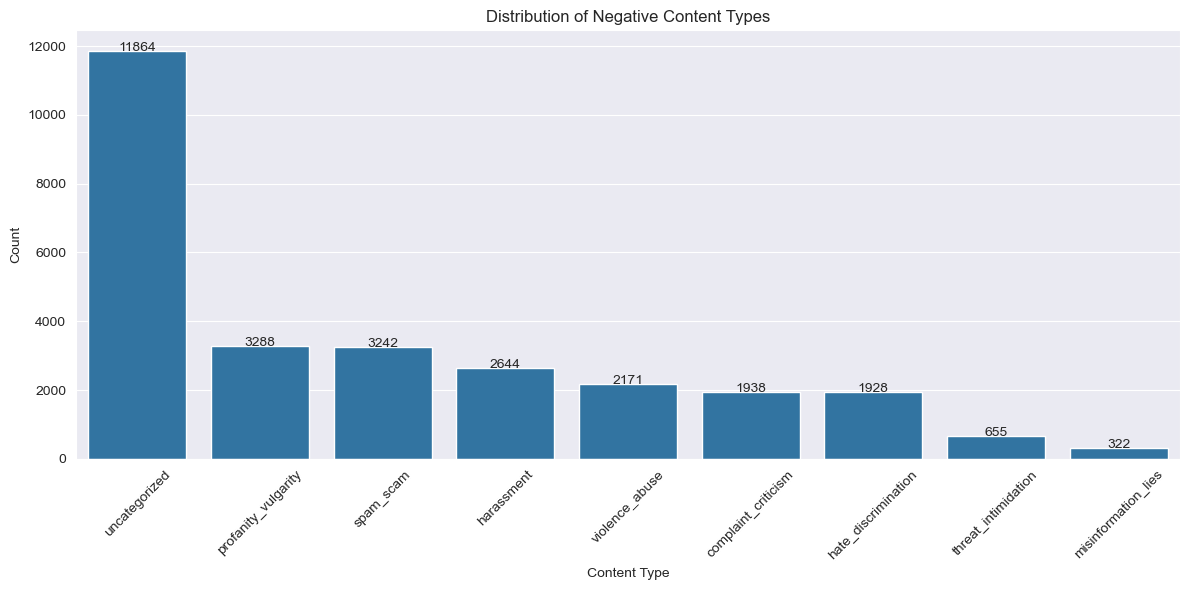

In [19]:
def visualize_content_types(df):
    """
    Visualize distribution of content types for negative texts
    """
    neg_content_types = df[df['labels'] == 0]['content_type'].value_counts()

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=neg_content_types.index, y=neg_content_types.values)
    plt.title('Distribution of Negative Content Types')
    plt.xlabel('Content Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Add count labels on top of bars
    for i, v in enumerate(neg_content_types.values):
        ax.text(i, v + 5, str(v), ha='center')

    plt.tight_layout()
    plt.show()

# Visualize content type distribution
visualize_content_types(df)

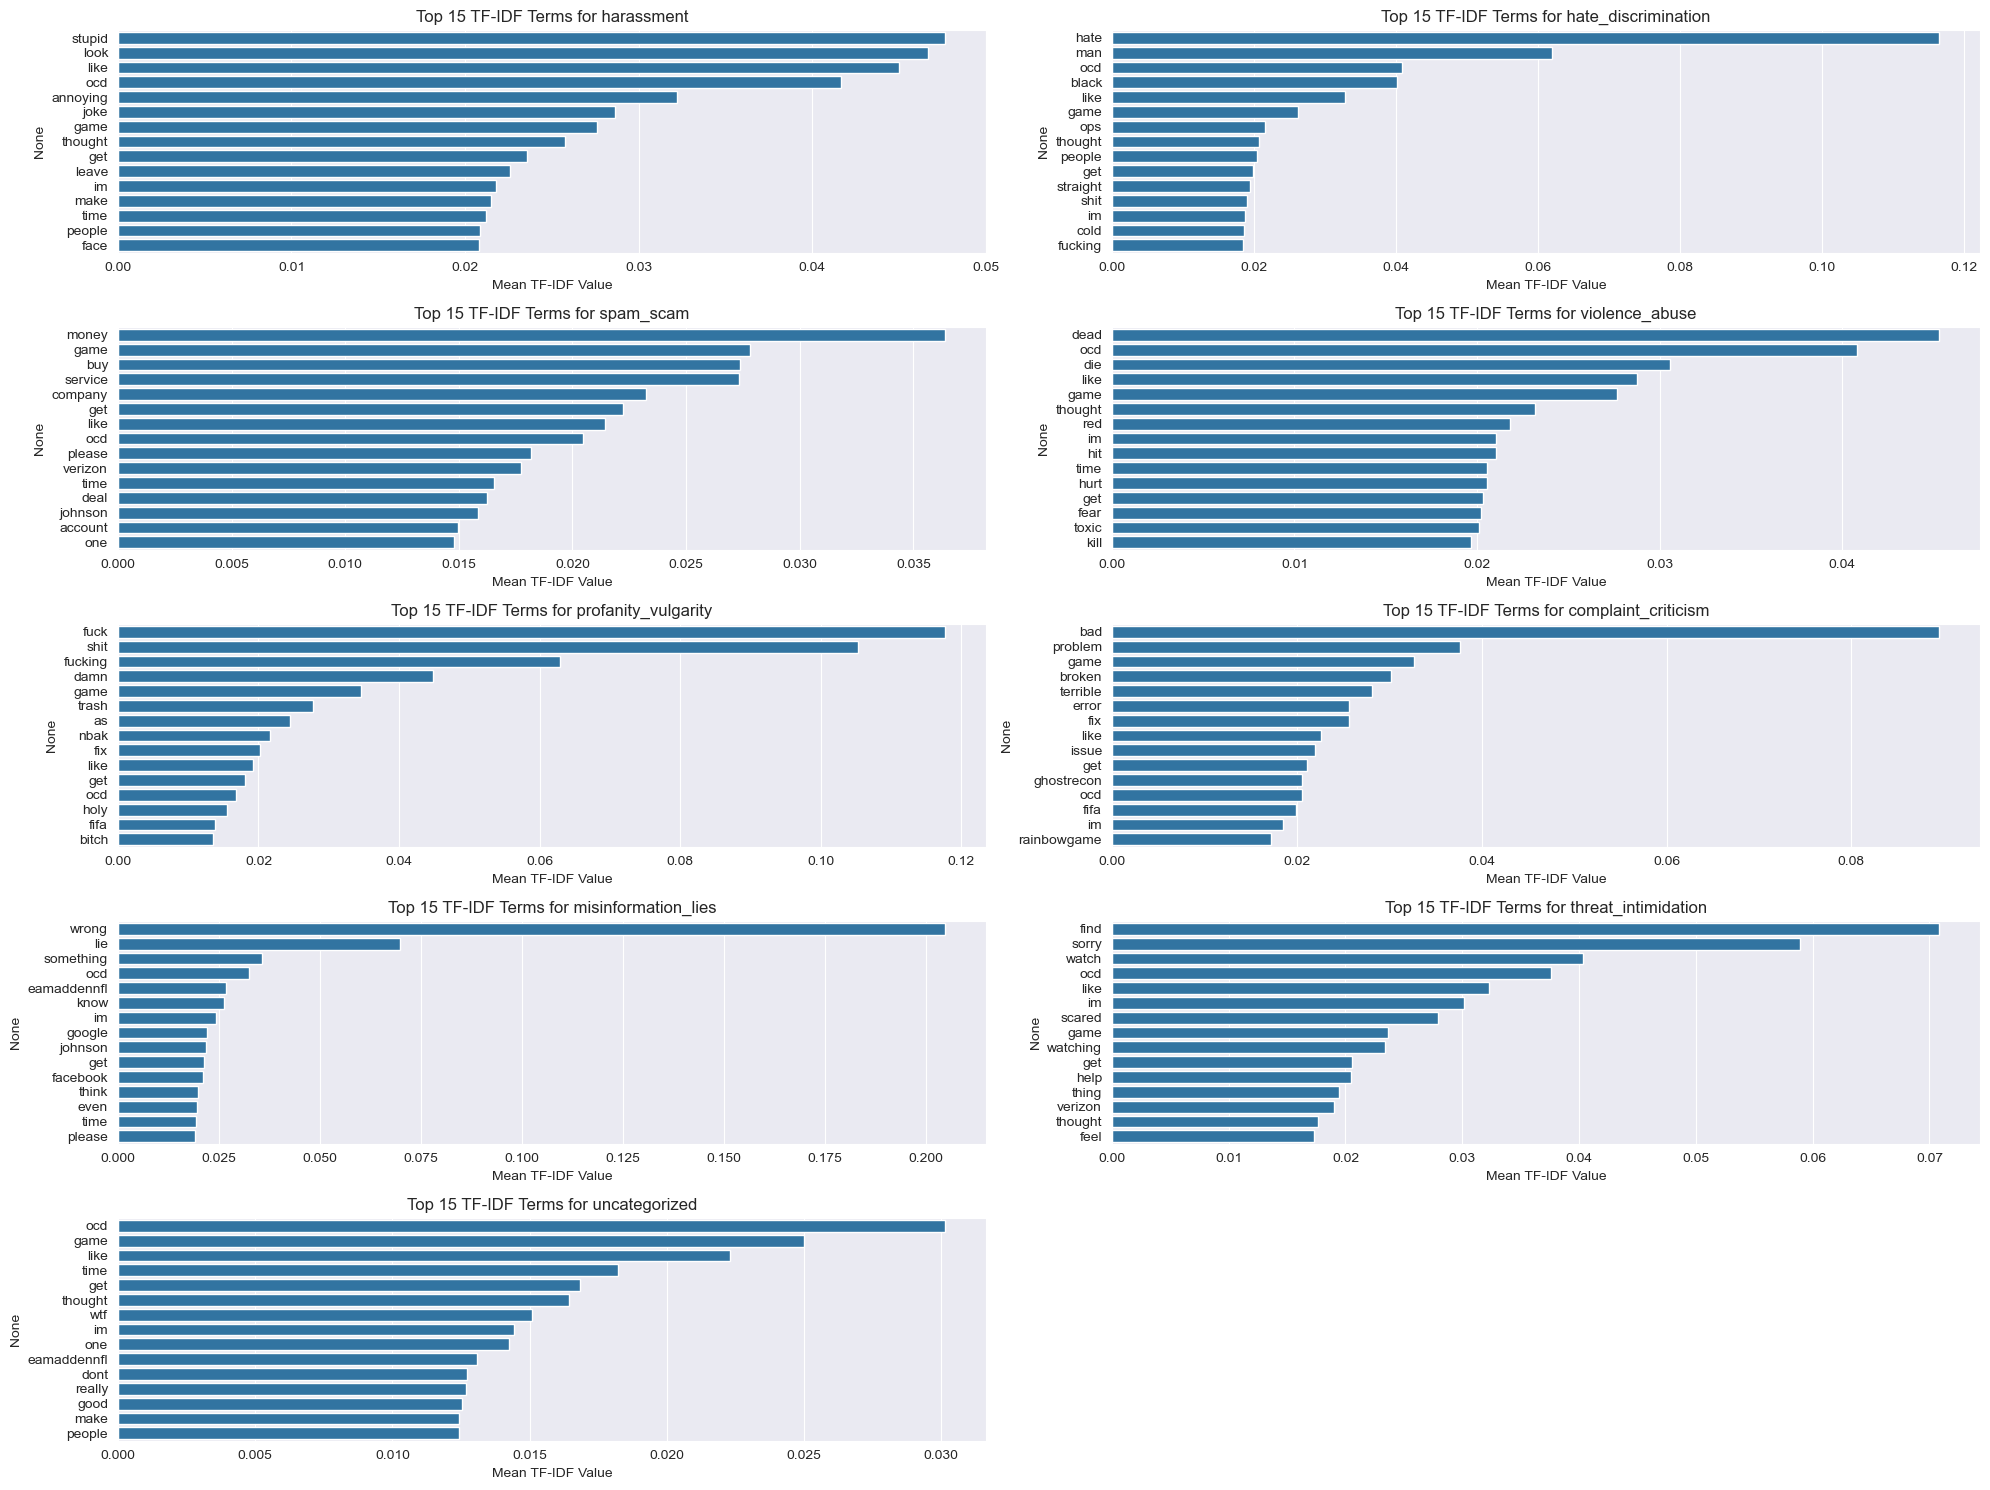

In [22]:
def visualize_tfidf_by_content_type(df, tfidf_df, feature_names, top_n=15):
    """
    Visualize top TF-IDF terms for each content type
    """
    content_types = [cat for cat in content_type_patterns.keys()]
    content_types.append('uncategorized')

    plt.figure(figsize=(20, 15))

    for i, content_type in enumerate(content_types):
        # Get indices of texts with this content type
        indices = df[(df['labels'] == 0) & (df['content_type'] == content_type)].index

        if len(indices) > 0:
            # Calculate mean TF-IDF values for this content type
            content_tfidf = tfidf_df.loc[indices].mean()

            # Get top terms
            top_indices = content_tfidf.nlargest(top_n).index
            top_values = content_tfidf.nlargest(top_n).values

            # Plot top terms
            plt.subplot(5, 2, i+1)
            sns.barplot(x=top_values, y=top_indices)
            plt.title(f'Top {top_n} TF-IDF Terms for {content_type}')
            plt.xlabel('Mean TF-IDF Value')
            plt.tight_layout()

    plt.show()

# Visualize TF-IDF terms by content type
visualize_tfidf_by_content_type(df, tfidf_df, feature_names)

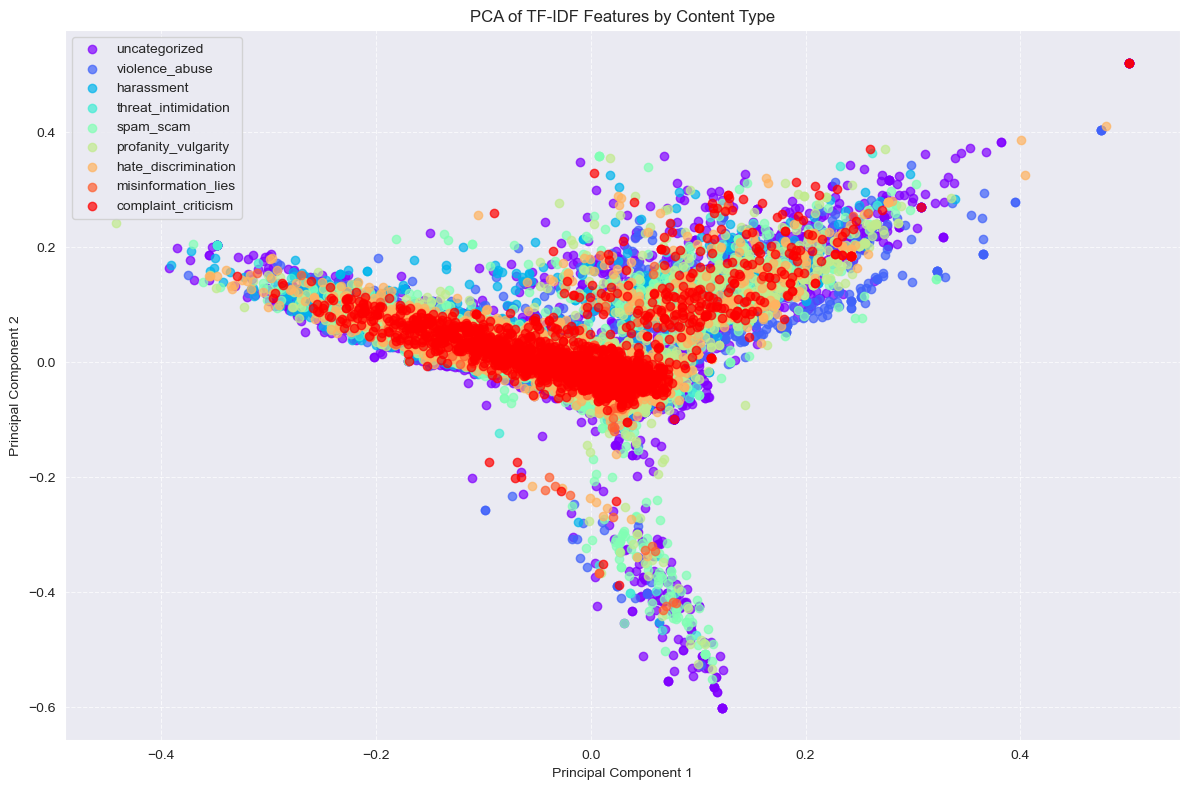

In [23]:
def visualize_pca_by_content_type(df, tfidf_df):
    """
    Visualize PCA of TF-IDF features colored by content type
    """
    # Apply PCA to reduce dimensions
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_df)

    # Create a dataframe for plotting
    pca_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
    pca_df['content_type'] = df['content_type']
    pca_df['sentiment'] = df['labels']

    # Only plot negative sentiment texts
    pca_neg = pca_df[pca_df['sentiment'] == 0]

    # Plot PCA
    plt.figure(figsize=(12, 8))

    # Get unique content types
    content_types = pca_neg['content_type'].unique()

    # Create a color map
    colors = plt.cm.rainbow(np.linspace(0, 1, len(content_types)))

    for i, content_type in enumerate(content_types):
        subset = pca_neg[pca_neg['content_type'] == content_type]
        plt.scatter(subset['PC1'], subset['PC2'], c=[colors[i]], label=content_type, alpha=0.7)

    plt.title('PCA of TF-IDF Features by Content Type')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize PCA
visualize_pca_by_content_type(df, tfidf_df)

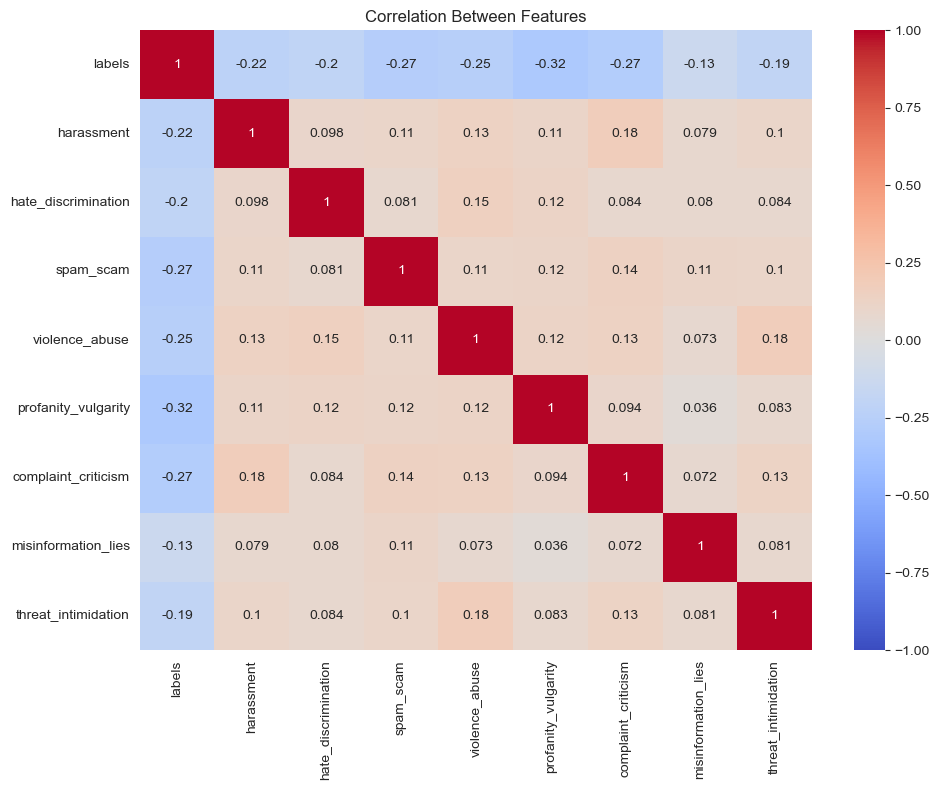

In [24]:
def create_feature_correlations(df):
    """
    Create correlation matrix of new features
    """
    # Select features for correlation
    features = ['labels'] + list(content_type_patterns.keys())
    corr_df = df[features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Features')
    plt.tight_layout()
    plt.show()

# Calculate feature correlations
create_feature_correlations(df)

In [25]:
def calculate_feature_importance(df, tfidf_vectorizer, feature_names):
    """
    Calculate importance of features for each content type
    """
    feature_importance = {}

    for content_type in content_type_patterns.keys():
        # Get indices of texts with this content type
        indices = df[(df['labels'] == 0) & (df['content_type'] == content_type)].index

        if len(indices) > 0:
            # Calculate mean TF-IDF values for this content type
            content_tfidf = tfidf_df.loc[indices].mean()

            # Get top terms
            top_indices = content_tfidf.nlargest(30).index
            top_values = content_tfidf.nlargest(30).values

            feature_importance[content_type] = dict(zip(top_indices, top_values))

    return feature_importance

# Calculate feature importance
feature_importance = calculate_feature_importance(df, tfidf_vectorizer, feature_names)

In [26]:
# Display feature importance for each category
print("\nTop features for each content type:")
for content_type, features in feature_importance.items():
    print(f"\n{content_type.upper()}:")
    for i, (term, importance) in enumerate(features.items()):
        print(f"  {i+1}. {term}: {importance:.4f}")


Top features for each content type:

HARASSMENT:
  1. stupid: 0.0476
  2. look: 0.0467
  3. like: 0.0450
  4. ocd: 0.0417
  5. annoying: 0.0322
  6. joke: 0.0287
  7. game: 0.0276
  8. thought: 0.0257
  9. get: 0.0236
  10. leave: 0.0226
  11. im: 0.0218
  12. make: 0.0215
  13. time: 0.0212
  14. people: 0.0209
  15. face: 0.0208
  16. fucking: 0.0205
  17. awful: 0.0196
  18. really: 0.0186
  19. feel: 0.0184
  20. thing: 0.0182
  21. know: 0.0180
  22. body: 0.0171
  23. one: 0.0162
  24. even: 0.0161
  25. dont: 0.0159
  26. go: 0.0156
  27. think: 0.0154
  28. fix: 0.0148
  29. something: 0.0147
  30. shit: 0.0128

HATE_DISCRIMINATION:
  1. hate: 0.1164
  2. man: 0.0619
  3. ocd: 0.0408
  4. black: 0.0401
  5. like: 0.0328
  6. game: 0.0262
  7. ops: 0.0215
  8. thought: 0.0207
  9. people: 0.0204
  10. get: 0.0198
  11. straight: 0.0194
  12. shit: 0.0190
  13. im: 0.0188
  14. cold: 0.0186
  15. fucking: 0.0184
  16. really: 0.0181
  17. war: 0.0180
  18. one: 0.0178
  19. time

In [27]:
# Create new features based on TF-IDF scores
print("\nCreating TF-IDF based features...")

# Get the top 50 overall TF-IDF terms
overall_tfidf = tfidf_df.mean()
top_overall_terms = overall_tfidf.nlargest(50).index

# Create new binary features for the presence of top terms
for term in top_overall_terms:
    df[f'has_{term}'] = (tfidf_df[term] > 0).astype(int)

    # Count ngrams by sentiment and content type
def count_ngrams(df, n=2):
    from nltk import ngrams

    ngram_counts = {}

    # Get ngrams for negative texts by content type
    for content_type in content_type_patterns.keys():
        texts = df[(df['labels'] == 0) & (df['content_type'] == content_type)]['cleaned_text']
        all_ngrams = []

        for text in texts:
            tokens = text.split()
            text_ngrams = list(ngrams(tokens, n))
            all_ngrams.extend([' '.join(gram) for gram in text_ngrams])

        # Count ngrams
        ngram_counts[content_type] = Counter(all_ngrams).most_common(20)

    return ngram_counts

# Get bigram counts
bigram_counts = count_ngrams(df, n=2)


Creating TF-IDF based features...


In [28]:
# Display top bigrams for each content type
print("\nTop bigrams for each content type:")
for content_type, bigrams in bigram_counts.items():
    print(f"\n{content_type.upper()}:")
    for i, (bigram, count) in enumerate(bigrams):
        print(f"  {i+1}. {bigram}: {count}")


Top bigrams for each content type:

HARASSMENT:
  1. look like: 151
  2. intrusive thought: 114
  3. feel like: 80
  4. go away: 58
  5. gon na: 46
  6. please fix: 33
  7. every time: 29
  8. series x: 27
  9. dont want: 27
  10. leave house: 26
  11. year ago: 26
  12. make sense: 26
  13. make feel: 25
  14. wan na: 25
  15. make sure: 25
  16. home depot: 24
  17. face mask: 23
  18. even though: 22
  19. anyone else: 21
  20. dont know: 20

HATE_DISCRIMINATION:
  1. black ops: 110
  2. cold war: 91
  3. ops cold: 82
  4. feel like: 70
  5. intrusive thought: 58
  6. call duty: 36
  7. fucking hate: 33
  8. league legend: 29
  9. home depot: 28
  10. gon na: 27
  11. assassin creed: 22
  12. duty black: 22
  13. rhandlerr rhandlerr: 20
  14. hate game: 20
  15. oh man: 17
  16. hate people: 17
  17. dont know: 17
  18. make sure: 17
  19. year old: 16
  20. got ta: 16

SPAM_SCAM:
  1. italy italy: 83
  2. johnson johnson: 82
  3. home depot: 68
  4. customer service: 64
  5. intru

In [29]:
# Add sentiment features using lexicon approach
def add_sentiment_features(df):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

    # Download VADER lexicon
    nltk.download('vader_lexicon')

    # Initialize VADER
    sid = SentimentIntensityAnalyzer()

    # Calculate sentiment scores
    df['sentiment_neg'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['neg'])
    df['sentiment_neu'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['neu'])
    df['sentiment_pos'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['pos'])
    df['sentiment_compound'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

    return df

# Add sentiment features
df = add_sentiment_features(df)

[nltk_data] Downloading package vader_lexicon to C:\Users\Jeff
[nltk_data]     Lam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
# Add text statistics features
def add_text_statistics(df):
    # Text length
    df['text_length'] = df['text'].apply(lambda x: len(str(x)))

    # Word count
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

    # Average word length
    df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)

    # Capital letter count
    df['capital_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))

    # Punctuation count
    df['punctuation_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c in '.,!?;:()[]{}'))

    # Special character count
    df['special_char_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if not c.isalnum() and not c.isspace()))

    # Digit count
    df['digit_count'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isdigit()))

    return df

# Add text statistics features
df = add_text_statistics(df)

In [31]:
# Display sample data with all features
print("\nSample data with all features:")
print(df.head())


Sample data with all features:
                                                text  labels  text_length  \
0  that might sound silly but if i havent pre-ord...       0          110   
1  googledofhey - i have no idea where else to tu...       1          138   
2        i just achieved the mana sponge achievement       1           43   
3  i go through this often when in a high up loca...       0          384   
4  mr paul christoph in sandrock best pubg teamma...       2          259   

   word_count                                       cleaned_text  harassment  \
0          22  might sound silly havent preordered fifa mean ...           0   
1          29  googledofhey idea else turn help google sheet ...           0   
2           7                   achieved mana sponge achievement           0   
3          74  go often high location could mall rooftop anyw...           0   
4          45  mr paul christoph sandrock best pubg teammate ...           0   

   hate_discrimination  

In [32]:
# Display summary statistics
print("\nSummary statistics for new features:")
print(df.describe())


Summary statistics for new features:
             labels   text_length    word_count    harassment  \
count  80000.000000  80000.000000  80000.000000  80000.000000   
mean       0.983450    137.139500     25.487638      0.033050   
std        0.827336    174.851991     33.303247      0.178768   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000     54.000000     10.000000      0.000000   
50%        1.000000     97.000000     17.000000      0.000000   
75%        2.000000    169.000000     31.000000      0.000000   
max        2.000000   7643.000000   1415.000000      1.000000   

       hate_discrimination     spam_scam  violence_abuse  profanity_vulgarity  \
count         80000.000000  80000.000000    80000.000000         80000.000000   
mean              0.027912      0.049712        0.042938             0.066437   
std               0.164723      0.217352        0.202717             0.249047   
min               0.000000      0.000000        0.00

In [33]:
# Save the enhanced dataframe
df.to_csv('enhanced_dataset.csv', index=False)

In [34]:
# 1. Prepare data for modeling
def prepare_data_for_modeling(df):
    """
    Prepare data for modeling by separating features and target
    """
    print("Preparing data for modeling...")

    # Define target
    y = df['labels']

    # Define text features
    text_data = df['cleaned_text']

    # Define numerical features (excluding text and targets)
    exclude_cols = ['text', 'cleaned_text', 'labels', 'content_type']
    numerical_features = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64']]

    # Define categorical features (if any)
    categorical_features = [col for col in df.columns if col not in exclude_cols + numerical_features and col != 'text' and col != 'cleaned_text']

    print(f"Target distribution: {Counter(y)}")
    print(f"Number of numerical features: {len(numerical_features)}")
    print(f"Number of categorical features: {len(categorical_features)}")

    return text_data, numerical_features, categorical_features, y

# 2. Split data
def split_data(text_data, df, numerical_features, y):
    """
    Split data into training and testing sets
    """
    print("Splitting data into training and testing sets...")

    X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
        text_data,
        df[numerical_features] if numerical_features else pd.DataFrame(),
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"Training set size: {len(X_train_text)}")
    print(f"Testing set size: {len(X_test_text)}")

    return X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test

In [35]:
# 1. Prepare data
text_data, numerical_features, categorical_features, y = prepare_data_for_modeling(df)

# 2. Split data
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = split_data(text_data, df, numerical_features, y)

# Create test dataframe for later use
df_test = pd.DataFrame({'cleaned_text': X_test_text})
for col in X_test_num.columns:
    df_test[col] = X_test_num[col].values
df_test['labels'] = y_test.values
if 'content_type' in df.columns:
    test_indices = X_test_text.index
    df_test['content_type'] = df.loc[test_indices, 'content_type'].values

Preparing data for modeling...
Target distribution: Counter({0: 28052, 2: 26728, 1: 25220})
Number of numerical features: 19
Number of categorical features: 50
Splitting data into training and testing sets...
Training set size: 64000
Testing set size: 16000


In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# 3. Create preprocessing pipeline
def create_preprocessing_pipeline(numerical_features):
    """
    Create preprocessing pipeline for text and numerical features
    """
    print("Creating preprocessing pipeline...")

    # Text preprocessing
    text_features = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7)),
        ('selector', SelectKBest(chi2, k=300))
    ])

    # Create preprocessing for numerical features if they exist
    if len(numerical_features) > 0:
        preprocessor = ColumnTransformer(
            transformers=[
                ('text', text_features, 'cleaned_text'),
                ('num', StandardScaler(), numerical_features)
            ],
            remainder='drop'
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('text', text_features, 'cleaned_text')
            ],
            remainder='drop'
        )

    return preprocessor

# 3. Create preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numerical_features)

Creating preprocessing pipeline...


In [37]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# 4. Define models to evaluate
def define_models():
    """
    Define models to evaluate
    """
    print("Defining models to evaluate...")

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }

    return models

# 4. Define models
models = define_models()

Defining models to evaluate...


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import time

# 5. Evaluate multiple models
def evaluate_models(X_train_text, X_train_num, y_train, X_test_text, X_test_num, y_test, models, preprocessor):
    """
    Train and evaluate multiple models
    """
    print("Evaluating models...")

    results = {}

    # Combine features for training and testing
    X_train_combined = pd.DataFrame({
        'cleaned_text': X_train_text
    })
    if not X_train_num.empty:
        for col in X_train_num.columns:
            X_train_combined[col] = X_train_num[col].values

    X_test_combined = pd.DataFrame({
        'cleaned_text': X_test_text
    })
    if not X_test_num.empty:
        for col in X_test_num.columns:
            X_test_combined[col] = X_test_num[col].values

    # Train and evaluate each model
    for name, model in models.items():
        start_time = time.time()
        print(f"Training {name}...")

        # Create a pipeline with preprocessor and model
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train model
        pipeline.fit(X_train_combined, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test_combined)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Calculate training time
        training_time = time.time() - start_time

        # Store results
        results[name] = {
            'model': pipeline,
            'accuracy': accuracy,
            'f1_score': f1,
            'report': report,
            'confusion_matrix': cm,
            'training_time': training_time
        }

        print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Training Time: {training_time:.2f} seconds")
        print(f"Classification Report:\n{report}")

    return results

# 5. Evaluate models
X_train_combined = pd.DataFrame({'cleaned_text': X_train_text})
if not X_train_num.empty:
    for col in X_train_num.columns:
        X_train_combined[col] = X_train_num[col].values

X_test_combined = pd.DataFrame({'cleaned_text': X_test_text})
if not X_test_num.empty:
    for col in X_test_num.columns:
        X_test_combined[col] = X_test_num[col].values

results = evaluate_models(X_train_text, X_train_num, y_train, X_test_text, X_test_num, y_test, models, preprocessor)


Evaluating models...
Training Logistic Regression...
Logistic Regression - Accuracy: 0.7188, F1 Score: 0.7231, Training Time: 6.12 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      5610
           1       0.63      0.69      0.66      5044
           2       0.66      0.71      0.68      5346

    accuracy                           0.72     16000
   macro avg       0.73      0.72      0.72     16000
weighted avg       0.73      0.72      0.72     16000

Training Random Forest...
Random Forest - Accuracy: 0.8108, F1 Score: 0.8125, Training Time: 130.18 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      5610
           1       0.77      0.82      0.79      5044
           2       0.76      0.81      0.78      5346

    accuracy                           0.81     16000
   macro avg       0.82      0.81      0.81     16000


Visualizing model evaluation results...


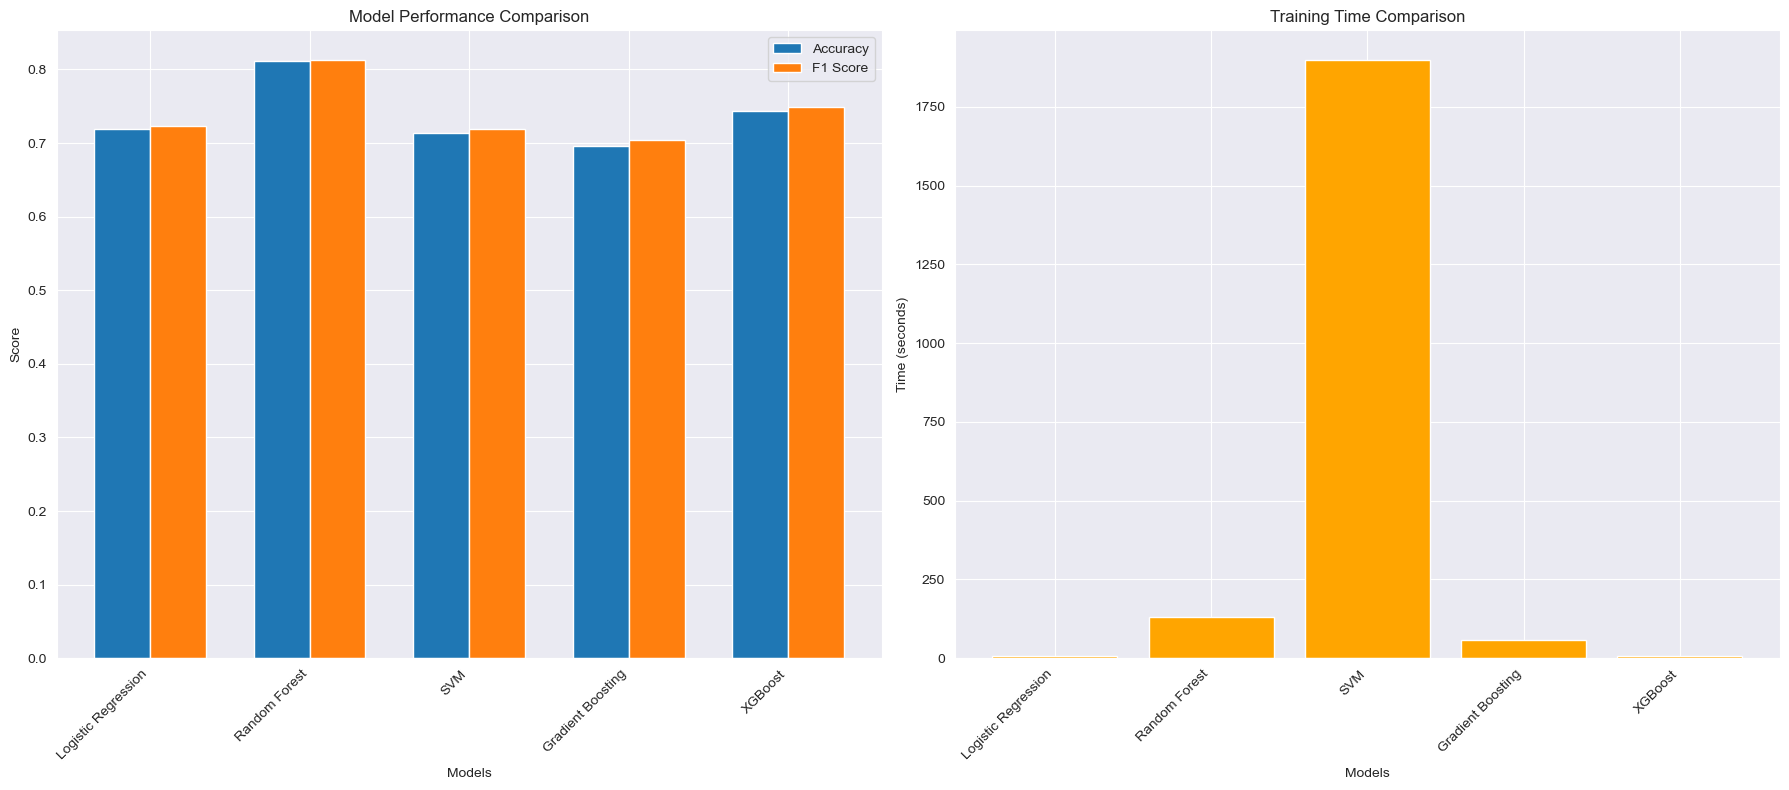

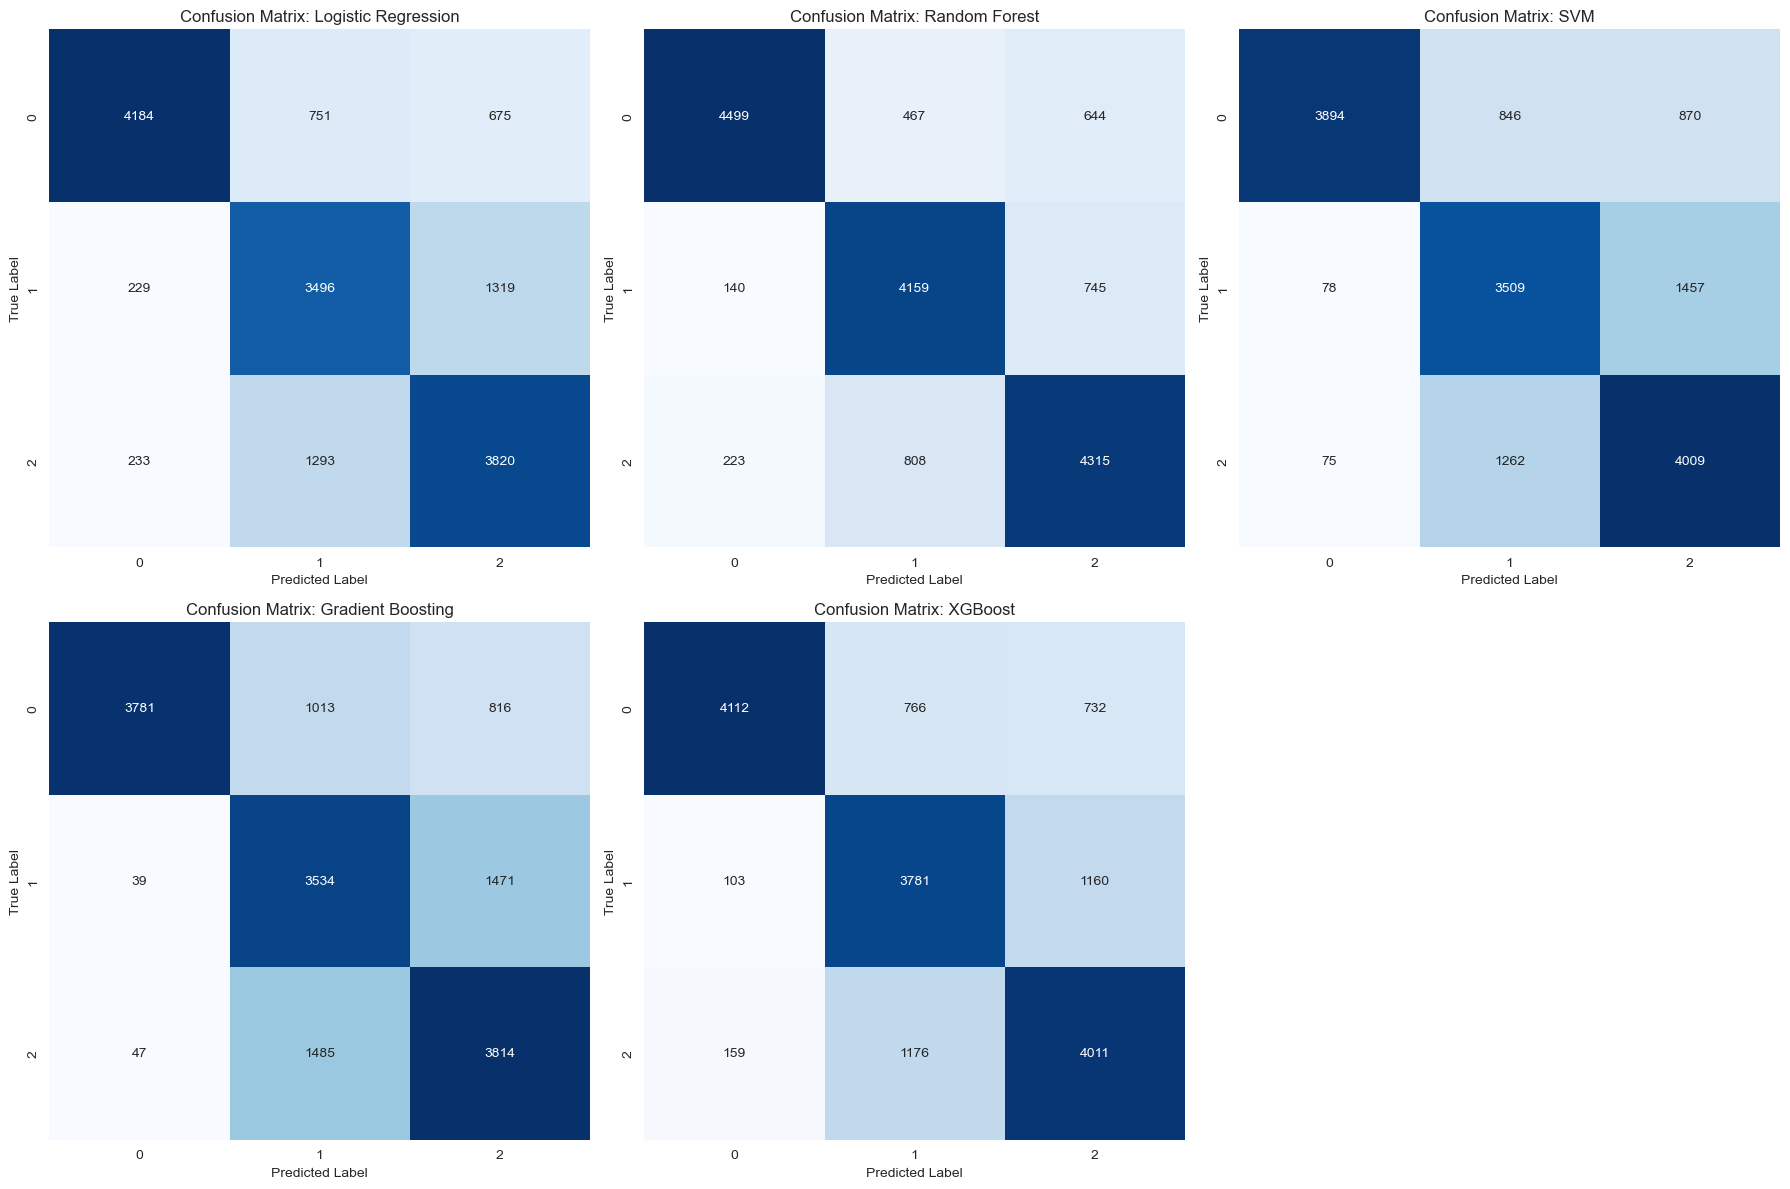

In [39]:
# 6. Visualize evaluation results
def visualize_results(results):
    """
    Visualize model evaluation results
    """
    print("Visualizing model evaluation results...")

    # Compare accuracy and F1 scores
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    f1_scores = [results[name]['f1_score'] for name in model_names]
    training_times = [results[name]['training_time'] for name in model_names]

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot accuracy and F1 score
    x = np.arange(len(model_names))
    width = 0.35

    axes[0].bar(x - width/2, accuracies, width, label='Accuracy')
    axes[0].bar(x + width/2, f1_scores, width, label='F1 Score')
    axes[0].set_title('Model Performance Comparison')
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Score')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0].legend()

    # Plot training time
    axes[1].bar(model_names, training_times, color='orange')
    axes[1].set_title('Training Time Comparison')
    axes[1].set_xlabel('Models')
    axes[1].set_ylabel('Time (seconds)')
    axes[1].set_xticklabels(model_names, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # Visualize confusion matrices
    plt.figure(figsize=(18, 12))

    for i, name in enumerate(model_names):
        plt.subplot(2, 3, i+1)
        cm = results[name]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: {name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

# 6. Visualize results
visualize_results(results)

In [40]:
# 7. Perform hyperparameter tuning for best model
def tune_best_model(best_model_name, X_train_combined, y_train, preprocessor):
    """
    Perform hyperparameter tuning for the best model
    """
    print(f"Tuning hyperparameters for {best_model_name}...")

    param_grids = {
        'Logistic Regression': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear', 'lbfgs'],
            'classifier__class_weight': [None, 'balanced']
        },
        'Random Forest': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__class_weight': [None, 'balanced']
        },
        'SVM': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto', 0.1]
        },
        'Gradient Boosting': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        },
        'XGBoost': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__subsample': [0.8, 1.0]
        }
    }

    # Get the best model and its parameter grid
    best_model = results[best_model_name]['model']
    param_grid = param_grids[best_model_name]

    # Create grid search
    grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )

    # Fit grid search
    grid_search.fit(X_train_combined, y_train)

    # Get best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    return grid_search.best_estimator_

# 7. Find best model based on F1 score
best_model_name = max(results.keys(), key=lambda k: results[k]['f1_score'])
print(f"Best model: {best_model_name} with F1 Score: {results[best_model_name]['f1_score']:.4f}")

Best model: Random Forest with F1 Score: 0.8125


In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# 8. Tune hyperparameters for best model
tuned_model = tune_best_model(best_model_name, X_train_combined, y_train, preprocessor)

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best cross-validation score: 0.8043


Evaluating final model...
Final Model - Accuracy: 0.8120, F1 Score: 0.8137
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      5610
           1       0.77      0.83      0.80      5044
           2       0.75      0.82      0.78      5346

    accuracy                           0.81     16000
   macro avg       0.82      0.81      0.81     16000
weighted avg       0.82      0.81      0.81     16000



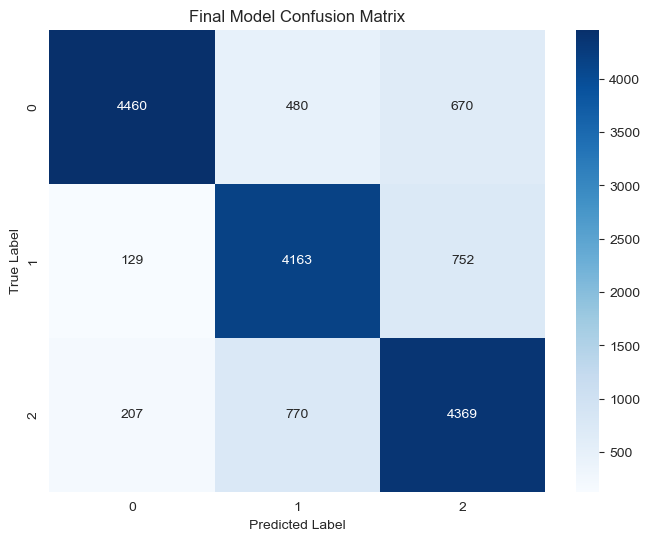

In [42]:
# 8. Evaluate final model
def evaluate_final_model(final_model, X_test_combined, y_test):
    """
    Evaluate final tuned model
    """
    print("Evaluating final model...")

    # Make predictions
    y_pred = final_model.predict(X_test_combined)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Final Model - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}")

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Final Model Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'report': report,
        'confusion_matrix': cm
    }

# 9. Evaluate final model
final_results = evaluate_final_model(tuned_model, X_test_combined, y_test)

In [43]:
# 10. Get feature names
if 'tfidf' in tuned_model.named_steps['preprocessor'].named_transformers_['text'].named_steps:
    tfidf = tuned_model.named_steps['preprocessor'].named_transformers_['text'].named_steps['tfidf']
    selector = tuned_model.named_steps['preprocessor'].named_transformers_['text'].named_steps['selector']

    all_feature_names = tfidf.get_feature_names_out()
    selected_indices = selector.get_support(indices=True)
    selected_feature_names = all_feature_names[selected_indices]

    # Add numerical feature names if they exist
    if not X_train_num.empty:
        feature_names = np.concatenate([selected_feature_names, np.array(numerical_features)])
    else:
        feature_names = selected_feature_names
else:
    feature_names = np.array(['feature_' + str(i) for i in range(100)])

Analyzing feature importance...


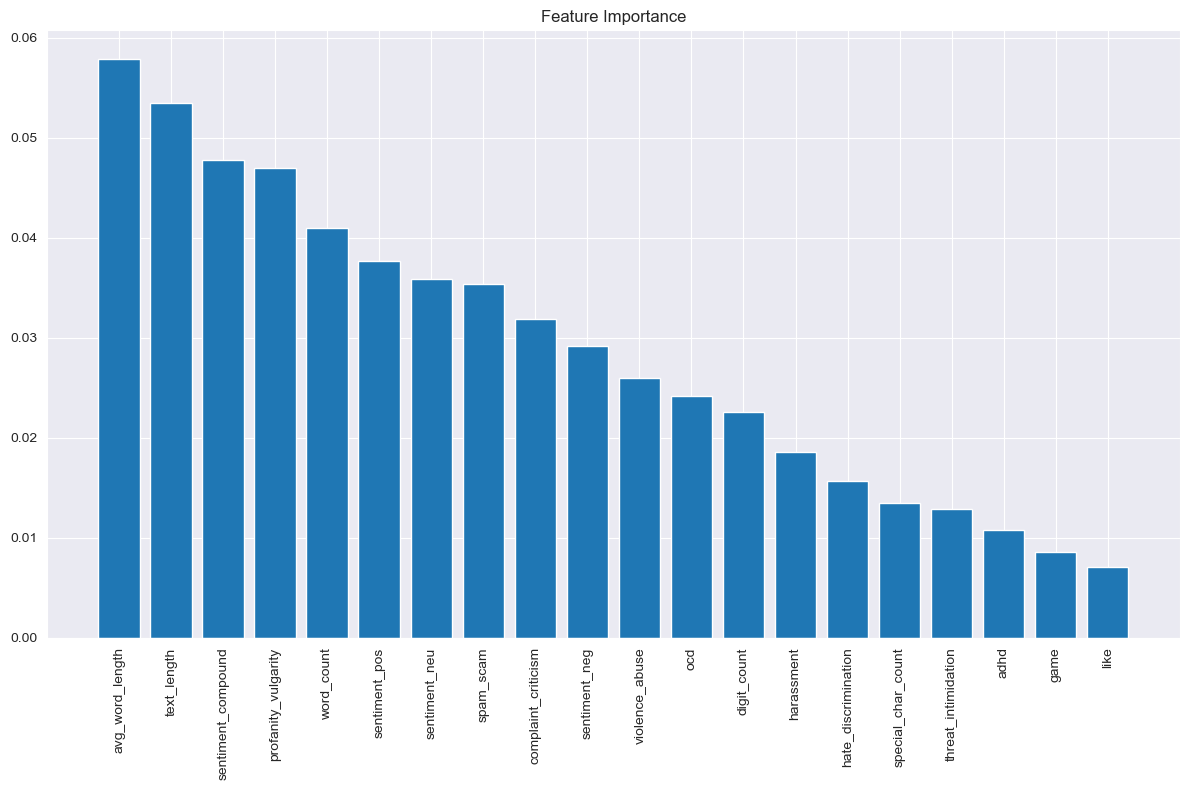

Top 20 features:
1. avg_word_length: 0.0579
2. text_length: 0.0535
3. sentiment_compound: 0.0478
4. profanity_vulgarity: 0.0470
5. word_count: 0.0410
6. sentiment_pos: 0.0377
7. sentiment_neu: 0.0359
8. spam_scam: 0.0354
9. complaint_criticism: 0.0319
10. sentiment_neg: 0.0292
11. violence_abuse: 0.0260
12. ocd: 0.0242
13. digit_count: 0.0226
14. harassment: 0.0186
15. hate_discrimination: 0.0157
16. special_char_count: 0.0134
17. threat_intimidation: 0.0128
18. adhd: 0.0107
19. game: 0.0086
20. like: 0.0071


In [44]:
# 9. Feature importance analysis
def analyze_feature_importance(final_model, feature_names):
    """
    Analyze feature importance for the final model
    """
    print("Analyzing feature importance...")

    # Get the classifier from the pipeline
    classifier = final_model.named_steps['classifier']

    # Check if the model has feature_importances_ attribute
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance')
        plt.bar(range(len(indices[:20])), importances[indices[:20]])
        plt.xticks(range(len(indices[:20])), [feature_names[i] for i in indices[:20]], rotation=90)
        plt.tight_layout()
        plt.show()

        # Print top features
        print("Top 20 features:")
        for i in range(20):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    # For models without feature_importances_ attribute (e.g., Logistic Regression)
    elif hasattr(classifier, 'coef_'):
        coefs = classifier.coef_

        # For multiclass, get absolute values and sum across classes
        if coefs.ndim > 1:
            importances = np.abs(coefs).sum(axis=0)
        else:
            importances = np.abs(coefs)

        indices = np.argsort(importances)[::-1]

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance')
        plt.bar(range(len(indices[:20])), importances[indices[:20]])
        plt.xticks(range(len(indices[:20])), [feature_names[i] for i in indices[:20]], rotation=90)
        plt.tight_layout()
        plt.show()

        # Print top features
        print("Top 20 features:")
        for i in range(20):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    else:
        print("This model doesn't support direct feature importance calculation.")

# 11. Analyze feature importance
analyze_feature_importance(tuned_model, feature_names)

Analyzing performance by content type...


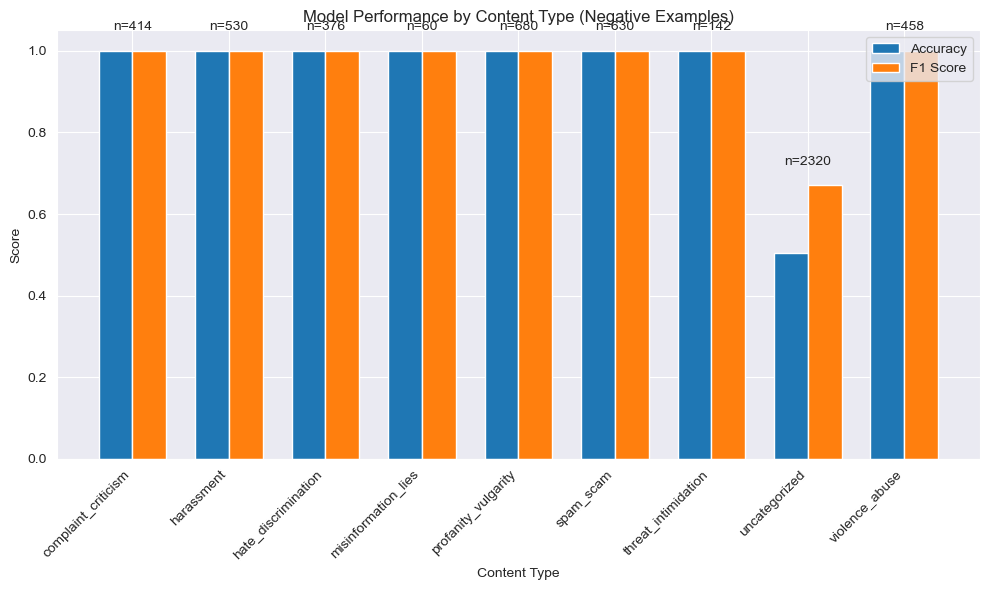

Performance by content type:
complaint_criticism (n=414): Accuracy = 1.0000, F1 Score = 1.0000
harassment (n=530): Accuracy = 1.0000, F1 Score = 1.0000
hate_discrimination (n=376): Accuracy = 1.0000, F1 Score = 1.0000
misinformation_lies (n=60): Accuracy = 1.0000, F1 Score = 1.0000
profanity_vulgarity (n=680): Accuracy = 1.0000, F1 Score = 1.0000
spam_scam (n=630): Accuracy = 1.0000, F1 Score = 1.0000
threat_intimidation (n=142): Accuracy = 1.0000, F1 Score = 1.0000
uncategorized (n=2320): Accuracy = 0.5043, F1 Score = 0.6705
violence_abuse (n=458): Accuracy = 1.0000, F1 Score = 1.0000


In [48]:
# 10. Analyze model performance by content type for negative examples
def analyze_performance_by_content_type(final_model, X_test_combined, y_test, df_test):
    """
    Analyze model performance by content type for negative examples
    """
    print("Analyzing performance by content type...")

    # Make predictions
    y_pred = final_model.predict(X_test_combined)

    # Get content types for test set
    content_types = df_test['content_type'].values

    # Calculate accuracy for each content type (for negative sentiment only)
    negative_indices = np.where(y_test == 0)[0]

    content_type_metrics = {}

    for content_type in np.unique(content_types):
        # Get indices where content_type matches and sentiment is negative
        type_indices = np.where((content_types == content_type) & (y_test == 0))[0]

        if len(type_indices) > 0:
            # Calculate accuracy and F1 score
            accuracy = accuracy_score(y_test.iloc[type_indices], y_pred[type_indices])
            f1 = f1_score(y_test.iloc[type_indices], y_pred[type_indices], average='weighted')


            content_type_metrics[content_type] = {
                'count': len(type_indices),
                'accuracy': accuracy,
                'f1_score': f1
            }

    # Visualize metrics by content type
    plt.figure(figsize=(10, 6))

    content_types = list(content_type_metrics.keys())
    accuracies = [content_type_metrics[ct]['accuracy'] for ct in content_types]
    f1_scores = [content_type_metrics[ct]['f1_score'] for ct in content_types]
    counts = [content_type_metrics[ct]['count'] for ct in content_types]

    x = np.arange(len(content_types))
    width = 0.35

    plt.bar(x - width/2, accuracies, width, label='Accuracy')
    plt.bar(x + width/2, f1_scores, width, label='F1 Score')

    plt.title('Model Performance by Content Type (Negative Examples)')
    plt.xlabel('Content Type')
    plt.ylabel('Score')
    plt.xticks(x, content_types, rotation=45, ha='right')
    plt.legend()

    # Add count labels on top of bars
    for i, v in enumerate(counts):
        plt.text(i, max(accuracies[i], f1_scores[i]) + 0.05, f"n={v}", ha='center')

    plt.tight_layout()
    plt.show()

    # Print metrics
    print("Performance by content type:")
    for content_type, metrics in content_type_metrics.items():
        print(f"{content_type} (n={metrics['count']}): Accuracy = {metrics['accuracy']:.4f}, F1 Score = {metrics['f1_score']:.4f}")


# 12. Analyze performance by content type
if 'content_type' in df.columns:
    analyze_performance_by_content_type(tuned_model, X_test_combined, y_test, df_test)

In [49]:
import joblib

# 11. Save the final model
def save_model(final_model, preprocessor, feature_names, filename='final_text_classification_model.pkl'):
    """
    Save the final model
    """
    print(f"Saving model to {filename}...")

    model_data = {
        'model': final_model,
        'preprocessor': preprocessor,
        'feature_names': feature_names
    }

    joblib.dump(model_data, filename)
    print("Model saved successfully!")

# 13. Save model
save_model(tuned_model, preprocessor, feature_names)

Saving model to final_text_classification_model.pkl...
Model saved successfully!


In [66]:
# 12. Example function to predict new text
def predict_text(model_data, text, numerical_features=None):
    """
    Predict sentiment and content type for new text
    """
    # Preprocess text
    data = {'cleaned_text': [text]}

    # Calculate required numerical features
    data['text_length'] = [len(text)]
    data['word_count'] = [len(text.split())]
    data['avg_word_length'] = [sum(len(word) for word in text.split()) / max(1, len(text.split()))]
    data['capital_count'] = [sum(1 for c in text if c.isupper())]
    data['punctuation_count'] = [sum(1 for c in text if c in '.,!?;:()[]{}')]
    data['special_char_count'] = [sum(1 for c in text if not c.isalnum() and not c.isspace())]
    data['digit_count'] = [sum(1 for c in text if c.isdigit())]

    # Add sentiment analysis features
    from nltk.sentiment import SentimentIntensityAnalyzer
    '''
    try:
        import nltk
        nltk.data.find('vader_lexicon')
    except LookupError:
        nltk.download('vader_lexicon')
    '''

    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    data['sentiment_neg'] = [sentiment_scores['neg']]
    data['sentiment_neu'] = [sentiment_scores['neu']]
    data['sentiment_pos'] = [sentiment_scores['pos']]
    data['sentiment_compound'] = [sentiment_scores['compound']]

    # Add binary content type features (initialize with zeros)
    content_types = [
        'harassment', 'hate_discrimination', 'spam_scam', 'violence_abuse',
        'threat_intimidation', 'misinformation_lies', 'profanity_vulgarity',
        'complaint_criticism'
    ]

    for content_type in content_types:
        data[content_type] = [0]  # Initialize with 0

    # Check for keywords to set content type features
    text_lower = text.lower()
    if any(word in text_lower for word in ['harass', 'bully']):
        data['harassment'] = [1]
    if any(word in text_lower for word in ['hate', 'discrimin']):
        data['hate_discrimination'] = [1]
    if any(word in text_lower for word in ['spam', 'scam']):
        data['spam_scam'] = [1]
    if any(word in text_lower for word in ['violen', 'abuse']):
        data['violence_abuse'] = [1]
    if any(word in text_lower for word in ['threat', 'intimidate']):
        data['threat_intimidation'] = [1]
    if any(word in text_lower for word in ['misinfo', 'lies', 'fake']):
        data['misinformation_lies'] = [1]
    if any(word in text_lower for word in ['profa', 'vulga', 'fuck', 'shit']):
        data['profanity_vulgarity'] = [1]
    if any(word in text_lower for word in ['complain', 'critic']):
        data['complaint_criticism'] = [1]

    # Add numerical features if provided
    if numerical_features is not None:
        for col, value in numerical_features.items():
            data[col] = [value]

    # Create DataFrame with features
    X = pd.DataFrame(data)

    # Get all required features from preprocessor if available
    if 'feature_names' in model_data and 'preprocessor' in model_data:
        # Option 1: Use the preprocessor directly
        try:
            X_processed = model_data['preprocessor'].transform(X)
            return process_prediction(model_data, X_processed)
        except Exception as e:
            print(f"Could not use preprocessor directly: {e}")

            # Option 2: Ensure all required columns exist
            required_features = model_data['feature_names']
            for feature in required_features:
                if feature not in X.columns:
                    X[feature] = 0  # Add missing columns with default values

    # Make prediction
    prediction = model_data['model'].predict(X)[0]
    probability = model_data['model'].predict_proba(X)[0]

    # Convert prediction to sentiment
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = sentiment_mapping[prediction]

    # Determine content type for negative sentiment
    content_type = 'uncategorized'  # Default
    if prediction == 0:
        # Find the content type with highest value
        content_values = {ct: X[ct].values[0] for ct in content_types if ct in X.columns}
        if content_values:
            max_type = max(content_values, key=content_values.get)
            if content_values[max_type] > 0:
                content_type = max_type

    result = {
        'sentiment': sentiment,
        'sentiment_id': prediction,
        'probability': probability.max(),
        'content_type': content_type
    }

    return result

def process_prediction(model_data, X_processed):
    """Helper function to process predictions from preprocessed data"""
    prediction = model_data['model'].predict(X_processed)[0]
    probability = model_data['model'].predict_proba(X_processed)[0]

    # Convert prediction to sentiment
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = sentiment_mapping[prediction]

    # Determine content type for negative sentiment
    content_type = 'uncategorized'
    if prediction == 0:
        # For preprocessed data, we can't easily determine the content type
        # You might need to extract this information differently
        pass

    result = {
        'sentiment': sentiment,
        'sentiment_id': prediction,
        'probability': probability.max(),
        'content_type': content_type
    }

    return result

# 14. Example prediction
sample_text = "I wanna show you my pokemon card"
model_data = {'model': tuned_model, 'preprocessor': preprocessor, 'feature_names': feature_names}
result = predict_text(model_data, sample_text)
print("\nExample prediction:")
print(f"Text: {sample_text}")
print(f"Prediction: {result['sentiment']} (confidence: {result['probability']:.4f})")
if result['sentiment'] == 'Negative':
    print(f"Content Type: {result['content_type']}")

Could not use preprocessor directly: X has 319 features, but ColumnTransformer is expecting 20 features as input.

Example prediction:
Text: I wanna show you my pokemon card
Prediction: Positive (confidence: 0.5194)
